In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import itertools
# Import FontProperties to handle Arabic text in plots
from matplotlib.font_manager import FontProperties
# Import libraries for correct Arabic text rendering
import arabic_reshaper
from bidi.algorithm import get_display

In [2]:
# Define the name of your Excel file.
excel_filename = 'population_hhld.xlsx'

# Read the 'data' and 'criteria' sheets directly from the Excel file.
# Using a try-except block to handle potential file/sheet not found errors.
try:
    data = pd.read_excel(excel_filename, sheet_name='data')
    criteria = pd.read_excel(excel_filename, sheet_name='criteria')
    print(f"Successfully read 'data' and 'criteria' sheets from '{excel_filename}'.")
except FileNotFoundError:
    print(f"Error: Make sure the Excel file ('{excel_filename}') is in the same directory as the script.")
    exit()
except ValueError as e:
    print(f"Error: Could not find a sheet named 'data' or 'criteria' in the Excel file. Details: {e}")
    exit()

Successfully read 'data' and 'criteria' sheets from 'population_hhld.xlsx'.


In [3]:
# --- Part 2: Data Processing and Transformation ---

In [4]:
# 2.1: Create the ind_cntry_yr DataFrame

# First, clean the 'Year' column in the original data by removing the 'Y' prefix and converting it to a numeric type.
# We use .loc to avoid SettingWithCopyWarning.
data.loc[:, 'Year'] = data['Year'].astype(str).str.replace('Y', '').astype(int)

# Define the full range of years we are interested in (2010-2025).
years_range = list(range(2010, 2026))

# Get unique indicators and countries from the data.
unique_indicators = data['Indicator'].unique()
unique_countries = data['Country'].unique()

# Create a master list of all possible combinations of Indicator, Country, and Year.
# This forms a complete grid with the empty years too to check data availability against.
all_combinations = list(itertools.product(unique_indicators, unique_countries, years_range))
ind_cntry_yr = pd.DataFrame(all_combinations, columns=['Indicator', 'Country', 'Year'])

# Merge the complete grid with the actual data.
# A 'left' merge keeps every combination from our master list.
# The 'indicator' tells us if a match was found in the original data.
ind_cntry_yr = pd.merge(
    ind_cntry_yr,
    data[['Indicator', 'Country', 'Year', 'Value']],
    on=['Indicator', 'Country', 'Year'],
    how='left'
)

# Create the 'Valid' column. If 'Value' is not NaN (meaning data was present),
# mark it as 1 (available), otherwise mark it as 0 (unavailable).
ind_cntry_yr['Valid'] = ind_cntry_yr['Value'].notna().astype(int)

# We no longer need the 'Value' column for this analysis.
ind_cntry_yr = ind_cntry_yr.drop(columns=['Value'])

#remove duplicate rows
ind_cntry_yr.drop_duplicates(inplace=True)

# Save the resulting DataFrame to an Excel file.
ind_cntry_yr.to_excel("ind_cntry_yr.xlsx", index=False)
print("Saved 'ind_cntry_yr.xlsx'")

Saved 'ind_cntry_yr.xlsx'


In [5]:
ind_cntry_yr[(ind_cntry_yr['Indicator']=='Age specific fertility rates') & (ind_cntry_yr['Country']=='Algeria')]

,Indicator,Country,Year,Valid
28726,Age specific fertility rates,Algeria,2010,1
28733,Age specific fertility rates,Algeria,2011,1
28740,Age specific fertility rates,Algeria,2012,1
28747,Age specific fertility rates,Algeria,2013,1
28754,Age specific fertility rates,Algeria,2014,1
28761,Age specific fertility rates,Algeria,2015,1
28768,Age specific fertility rates,Algeria,2016,1
28775,Age specific fertility rates,Algeria,2017,1
28782,Age specific fertility rates,Algeria,2018,1
28789,Age specific fertility rates,Algeria,2019,1


In [6]:
# 2.2: Create the ind_cntry DataFrame

# Group by Indicator and Country, and sum the 'Valid' column to count available years.
ind_cntry_grouped = ind_cntry_yr.groupby(['Indicator', 'Country'])['Valid'].sum().reset_index()
ind_cntry_grouped = ind_cntry_grouped.rename(columns={'Valid': 'num_available_years'})

# Merge the grouped data with the criteria DataFrame to get the required number of years for each indicator.
ind_cntry = pd.merge(
    ind_cntry_grouped,
    criteria,
    on='Indicator',
    how='left'
)

# Create the 'Available' column. If the number of available years meets or exceeds
# the criteria, mark as 1, otherwise 0.
ind_cntry['Available'] = (ind_cntry['num_available_years'] >= ind_cntry['number of years']).astype(int)

# Save the resulting DataFrame to an Excel file.
ind_cntry.to_excel("ind_cntry.xlsx", index=False)
print("Saved 'ind_cntry.xlsx'")

Saved 'ind_cntry.xlsx'


In [7]:
ind_cntry[ind_cntry['Indicator']=='Age specific fertility rates']

,Indicator,Country,num_available_years,number of years,Available
0,Age specific fertility rates,Algeria,10,7,1
1,Age specific fertility rates,Bahrain,12,7,1
2,Age specific fertility rates,Comoros,1,7,0
3,Age specific fertility rates,Djibouti,0,7,0
4,Age specific fertility rates,Egypt,12,7,1
5,Age specific fertility rates,Iraq,12,7,1
6,Age specific fertility rates,Jordan,13,7,1
7,Age specific fertility rates,Kuwait,12,7,1
8,Age specific fertility rates,Lebanon,12,7,1
9,Age specific fertility rates,Libya,12,7,1


In [8]:
# 2.3: Create the ind_availabilty DataFrame (based on your step 5)

# Calculate the number of unique countries.
total_countries = ind_cntry['Country'].nunique()

# Group by Indicator and calculate the availability percentage.
# This shows what percentage of countries have sufficient data for each indicator.
ind_availabilty = ind_cntry.groupby('Indicator')['Available'].sum().reset_index()
ind_availabilty['ind availabilty'] = (ind_availabilty['Available'] / total_countries) * 100

# Save the resulting DataFrame to an Excel file.
ind_availabilty.to_excel("ind_availabilty.xlsx", index=False)
print("Saved 'ind_availabilty.xlsx'")

Saved 'ind_availabilty.xlsx'


In [9]:
ind_availabilty

,Indicator,Available,ind availabilty
0,Age specific fertility rates,19,86.363636
1,Average annual population growth rate (%),20,90.909091
2,Children (<5 years) mortality rates,19,86.363636
3,Female headed households occupied housing unit...,4,18.181818
4,Infant (<1) mortality rates,19,86.363636
5,International migrant stock,4,18.181818
6,Life expectancy at birth for total population,20,90.909091
7,Mean age at first marriage,4,18.181818
8,Occupied housing units by average household si...,8,36.363636
9,Population Size,19,86.363636


In [10]:
# 2.4: Create the cntry_availabilty DataFrame (based on your step 6)

# Calculate the number of unique indicators.
total_indicators = ind_cntry['Indicator'].nunique()

# Group by Country and calculate the availability percentage.
# This shows what percentage of required indicators are available for each country.
cntry_availabilty = ind_cntry.groupby('Country')['Available'].sum().reset_index()
cntry_availabilty['cntry availabilty'] = (cntry_availabilty['Available'] / total_indicators) * 100

# Calculate the average availability across all countries.
region_avg = cntry_availabilty['cntry availabilty'].mean()
cntry_availabilty['region availabilty'] = region_avg

# Save the resulting DataFrame to an Excel file.
cntry_availabilty.to_excel("cntry_availabilty.xlsx", index=False)
print("Saved 'cntry_availabilty.xlsx'")

Saved 'cntry_availabilty.xlsx'


In [11]:
cntry_availabilty

,Country,Available,cntry availabilty,region availabilty
0,Algeria,13,81.25,70.454545
1,Bahrain,13,81.25,70.454545
2,Comoros,0,0.00,70.454545
3,Djibouti,6,37.50,70.454545
4,Egypt,14,87.50,70.454545
5,Iraq,13,81.25,70.454545
6,Jordan,15,93.75,70.454545
7,Kuwait,13,81.25,70.454545
8,Lebanon,9,56.25,70.454545
9,Libya,10,62.50,70.454545


In [12]:
# --- Part 3: Generate Charts ---

C:\Users\511232\AppData\Local\Temp\ipykernel_29076\2946304044.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


Saved 'country_availability_barchart.png'


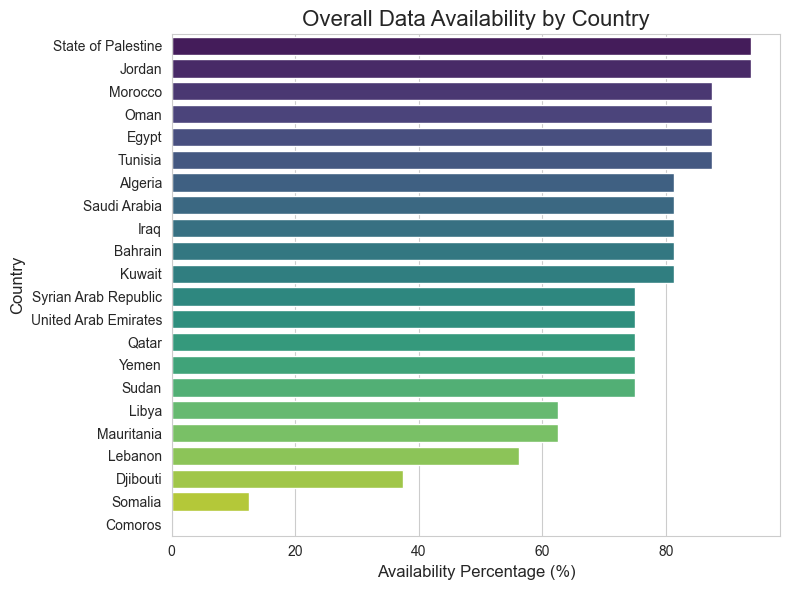

In [13]:
# 3.1: Barchart for Overall Country Availability

# --- EDITABLE TITLE FOR THE BARCHART ---
barchart_title = "Overall Data Availability by Country"

# Sort the data for the chart in descending order.
cntry_availabilty_sorted = cntry_availabilty.sort_values('cntry availabilty', ascending=False)

# Set the style and figure size for the plot.
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

# Create the horizontal bar plot.
barplot = sns.barplot(
    x='cntry availabilty',
    y='Country',
    data=cntry_availabilty_sorted,
    palette='viridis'
)

# Set the title and labels.
plt.title(barchart_title, fontsize=16)
plt.xlabel("Availability Percentage (%)", fontsize=12)
plt.ylabel("Country", fontsize=12)

# Show the plot.
plt.tight_layout()
plt.savefig("country_availability_barchart.png")
print("Saved 'country_availability_barchart.png'")
plt.show()

Generating charts...


C:\Users\511232\AppData\Local\Temp\ipykernel_29076\2434376267.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


Saved 'country_availability_barchart.png'


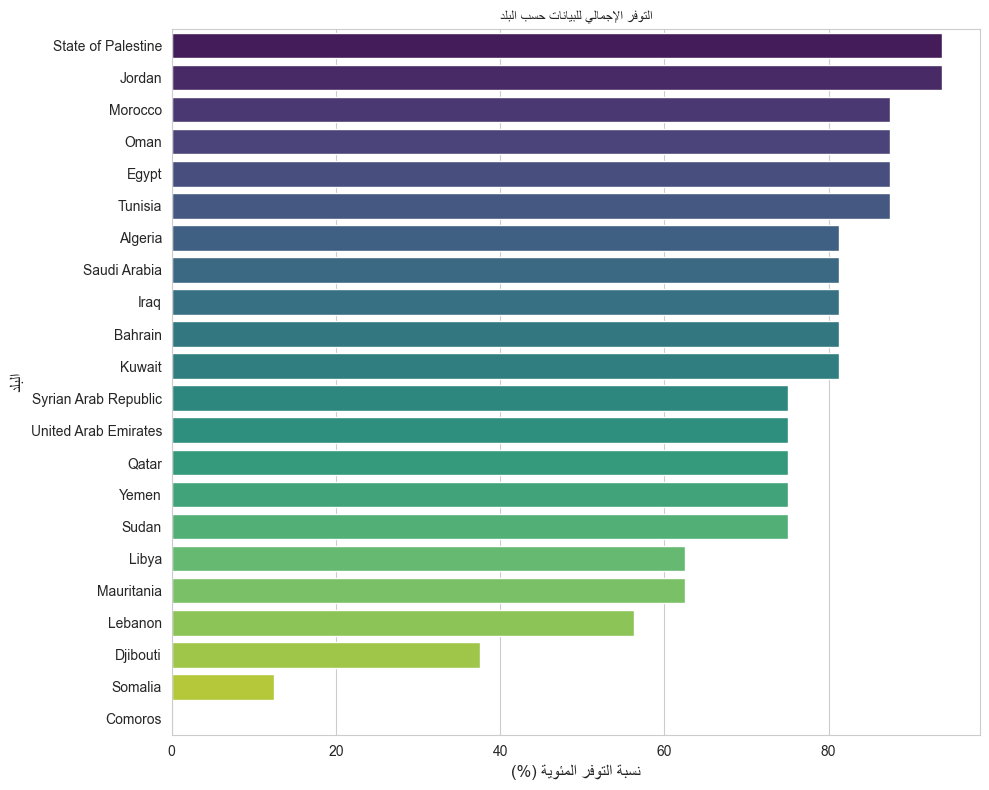

In [18]:
######################################################arabic chart#################################
print("Generating charts...")

# Define a font property that supports Arabic.
# NOTE: You must have a font that supports Arabic installed on your system, such as 'Arial' or 'Tahoma'.
try:
    font_prop = FontProperties(family='Arial')
except:
    print("Warning: Could not find Arial font. Arabic text in the chart may not render correctly.")
    font_prop = FontProperties() # Fallback to default font

# 3.1: Barchart for Overall Country Availability

# Process Arabic labels for correct display
barchart_title_raw = "التوفر الإجمالي للبيانات حسب البلد"
xlabel_raw = "نسبة التوفر المئوية (%)"
ylabel_raw = "البلد"

barchart_title = get_display(arabic_reshaper.reshape(barchart_title_raw))
xlabel = get_display(arabic_reshaper.reshape(xlabel_raw))
ylabel = get_display(arabic_reshaper.reshape(ylabel_raw))

# Sort the data for the chart in descending order.
cntry_availabilty_sorted = cntry_availabilty.sort_values('cntry availabilty', ascending=False)

# Set the style and figure size for the plot.
sns.set_style("whitegrid")
plt.figure(figsize=(10, 8))

# Create the horizontal bar plot.
barplot = sns.barplot(
    x='cntry availabilty',
    y='Country',
    data=cntry_availabilty_sorted,
    palette='viridis'
)

# Set the title and labels, applying the Arabic font property.
plt.title(barchart_title, fontsize=16, fontproperties=font_prop)
plt.xlabel(xlabel, fontsize=12, fontproperties=font_prop)
plt.ylabel(ylabel, fontsize=12, fontproperties=font_prop)

# Display the plot.
plt.tight_layout()
plt.savefig("country_availability_barchart.png")
print("Saved 'country_availability_barchart.png'")

In [ ]:
# 3.2: Heatmap for a Specific Indicator

# --- EDITABLE INDICATOR AND TITLE FOR THE HEATMAP ---
# Change the indicator_to_plot value to any indicator from your data.
indicator_to_plot = "Population estimates"
heatmap_title = f"Data Availability for: {indicator_to_plot}"

# Filter the data for the selected indicator.
heatmap_data = ind_cntry_yr[ind_cntry_yr['Indicator'] == indicator_to_plot]

# Check if the indicator exists to avoid errors.
if heatmap_data.empty:
    print(f"Error: Indicator '{indicator_to_plot}' not found in the data. Please check the name.")
else:
    # Pivot the data to create a matrix of Country vs. Year.
    heatmap_pivot = heatmap_data.pivot_table(
        index='Country',
        columns='Year',
        values='Valid',
        fill_value=0  # Ensure that any missing combinations are filled with 0.
    )

    # Set the figure size.
    plt.figure(figsize=(18, 10))

    # Create the heatmap.
    # We use a custom colormap: grey for 0 (unavailable) and green for 1 (available).
    # cbar=False hides the color bar, annot=False hides the data values (0s and 1s).
    sns.heatmap(
        heatmap_pivot,
        cmap=ListedColormap(['#d3d3d3', '#2ca02c']), # grey, green
        linewidths=.5,
        linecolor='white',
        cbar=False,
        annot=False
    )

    # Set the title and labels.
    plt.title(heatmap_title, fontsize=16)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Country", fontsize=12)
    plt.xticks(rotation=45) # Rotate x-axis labels for better readability.

    # Show the plot.
    plt.tight_layout()
    plt.savefig("indicator_availability_heatmap.png")
    print("Saved 'indicator_availability_heatmap.png'")
    plt.show()